In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

In [3]:
import pandas as pd
from utilities_functions.intermediate_layer_extraction import return_layer_input
from utilities_functions.ri_calculator import find_smallest_variation_to_change
import deepmatcher as dm
import torch

In [4]:
attributes =['Beer_Name','Brew_Factory_Name','Style','ABV']

In [5]:
model = dm.MatchingModel(attr_summarizer='hybrid')
model.load_state('../../models/beer_hybrid.pth')

In [6]:
neg_classifier_inputs,neg_ids = return_layer_input('../../Structured/Beer/'
                                                                         ,'negatives',128,model,
                                                                        model.classifier,device=-1)


Reading and processing data from "../../Structured/Beer/negatives.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [7]:
pos_classifier_inputs,pos_ids = return_layer_input('../../Structured/Beer',
                                                                       'positives',64,model,
                                                                       model.classifier,device=-1)


Reading and processing data from "../../Structured/Beer/positives.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [7]:
testneg_classifier_inputs,testneg_classifier_outputs,testneg_ids = return_layer_input_output('../../Structured/Beer/'
                                                                         ,'test_negatives',32,model,
                                                                        model.classifier)

In [9]:
testpos_classifier_inputs,testpos_classifier_outputs,testpos_ids = return_layer_input_output('../../Structured/Beer',
                                                                       'test_positives',32,model,
                                                                       model.classifier)

In [8]:
attribute_length = int((300*3)/len(attributes))
classifier_length = int(attribute_length*len(attributes))

In [9]:
model = model.cuda()

In [10]:
from tqdm import tqdm

In [12]:
current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri = []
for batch in neg_classifier_inputs:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(model.classifier,
                                                                                    classifier_length=classifier_length,
                                                                                    attribute_length=attribute_length,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=1,
                                                                                   learning_rate=1),attributes))
        negatives_ri.append(current_sample_ris)
        current_sample+=1

100%|██████████| 128/128 [02:19<00:00,  1.14s/it]


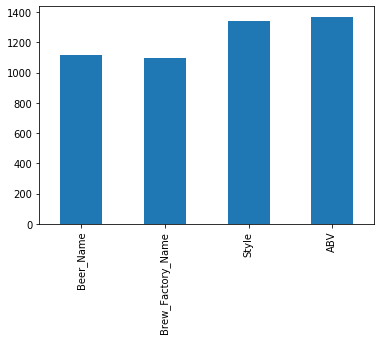

In [14]:
ri_norms_negative_samples = []
for ri_list in negatives_ri:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
negatives_variation_df = pd.DataFrame(data= ri_norms_negative_samples,columns=attributes)
negatives_variation_df.sum().plot.bar()

In [31]:
negatives_variation_df.to_csv('experiment-results/negatives_ri_v2.csv',index=False)

In [15]:
current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri = []
for batch in pos_classifier_inputs:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(model.classifier,
                                                                                    classifier_length=classifier_length,
                                                                                    attribute_length=attribute_length,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=0,
                                                                                   learning_rate=2),attributes))
        positives_ri.append(current_sample_ris)
        current_sample+=1

100%|██████████| 64/64 [00:57<00:00,  1.08it/s]


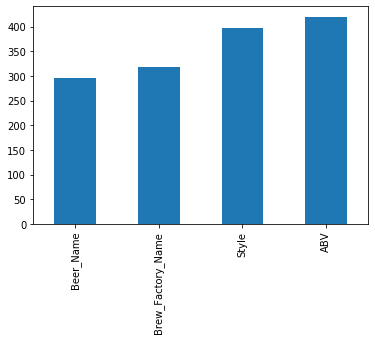

In [16]:
ri_norms_positives = []
for ri_list in positives_ri:
    ri_norms_positives.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
positives_variation_df = pd.DataFrame(data= ri_norms_positives,columns=attributes)
positives_variation_df.sum().plot.bar()

In [17]:
positives_variation_df.to_csv('experiment-results/positives_ri_v2.csv',index=False)

## Compute closer vectors

In [18]:
from utilities_functions.distance_measures import nearest_neighbour,nearest_neighbour_onAttribute

In [20]:
#lista di tuple: vettore più vicino considerando tutti gli elementi e closer solo secondo un attributo
negatives_closer_vectors = []
i = 0
for batch in neg_classifier_inputs:
    for sample in tqdm(batch):
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbour_onAttribute
                                                 (sample+negatives_ri[i][attributes.index(att)]
                                                                ,pos_classifier_inputs,attributes.index(att),
                                                                attribute_length,'cosine'),attributes))
        negatives_closer_vectors.append(current_sample_closer_vectors)
        i += 1 

100%|██████████| 128/128 [00:05<00:00, 22.55it/s]


In [23]:
# per ogni attributo trovo il più vicino
positives_closer_vectors = []
i = 0
for batch in pos_classifier_inputs:
    for sample in tqdm(batch):
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbour_onAttribute
                                                 (sample+positives_ri[i][attributes.index(att)]
                                                                ,neg_classifier_inputs,attributes.index(att),
                                                                attribute_length,'cosine'),attributes))
        positives_closer_vectors.append(current_sample_closer_vectors)
        i += 1 

100%|██████████| 64/64 [00:15<00:00,  4.14it/s]


In [24]:
positives_closer_vectors_df = pd.DataFrame(data= positives_closer_vectors,columns =attributes)
positives_closer_vectors_df = positives_closer_vectors_df.applymap(lambda c:neg_ids[c])

In [25]:
negatives_closer_vectors_df = pd.DataFrame(data = negatives_closer_vectors, columns = attributes)
negatives_closer_vectors_df = negatives_closer_vectors_df.applymap(lambda c:pos_ids[c])

In [27]:
positives_closer_vectors_df['SampleID'] = pos_ids
negatives_closer_vectors_df['SampleID'] = neg_ids

In [28]:
positives_closer_vectors_df.to_csv('experiment-results/positives_nn.csv',index=False)
negatives_closer_vectors_df.to_csv('experiment-results/negatives_nn.csv',index=False)

## Test nearest neighbours

In [35]:
!mkdir temp

In [29]:
negatives = pd.read_csv('../../Structured/Beer/negatives.csv')
positives = pd.read_csv('../../Structured/Beer/positives.csv')

In [30]:
from utilities_functions.explainer import generateExplanations,analyze_valueDistribution

In [31]:
positives_closer_vectors_df = pd.read_csv("experiment-results/positives_nn.csv")

In [32]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/beer_hybrid.pth')

In [37]:
top5NN = generateExplanations(positives_closer_vectors_df,10,negatives,"Beer_Name",hybrid_model,
                    "../../Structured/Beer/positives.csv",1)


Reading and processing data from "../../Structured/Beer/positives.csv"
0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 8



Reading and processing data from "temp/altered_test0.csv"


Finished Epoch 8 || Run Time:    0.1 | Load Time:    0.0 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

The standard true positives are 64
Pike Old Bawdy Barley Wine | Bristol Old No. 23 Barley Wine


0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 8



Reading and processing data from "temp/altered_test1.csv"


Finished Epoch 8 || Run Time:    0.1 | Load Time:    0.0 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

62
Iron Mike 's Amber Ale | Railway City Iron Spike Amber Ale


0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 8



Reading and processing data from "temp/altered_test2.csv"


Finished Epoch 8 || Run Time:    0.1 | Load Time:    0.0 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

31
Alaskan Imperial Red Ale ( Pilot Series ) | Swamp Head Sciaenhops Imperial Red Ale


0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 8



Reading and processing data from "temp/altered_test3.csv"


Finished Epoch 8 || Run Time:    0.1 | Load Time:    0.0 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

0
Beer Of The Dragon | Anderson Valley Barrel Aged Horn of the Beer Barley Wine


0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 8



Reading and processing data from "temp/altered_test4.csv"


Finished Epoch 8 || Run Time:    0.1 | Load Time:    0.0 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

26
Harold The Red Ale | Off the Rail Raybuck Red Ale


0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 8
Finished Epoch 8 || Run Time:    0.1 | Load Time:    0.0 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

21



Reading and processing data from "temp/altered_test5.csv"


Winter Seasonal Amber Ale | Brewsters Winter WARMer Amber Ale


0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 8



Reading and processing data from "temp/altered_test6.csv"


Finished Epoch 8 || Run Time:    0.1 | Load Time:    0.0 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

51
Twisted Stick Amber Ale | Sick N Twisted Pleasure Victim Amber Ale


0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 8



Reading and processing data from "temp/altered_test7.csv"


Finished Epoch 8 || Run Time:    0.1 | Load Time:    0.0 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

29
Big Bear Amber Ale | Big Horn Buttface Amber Ale


0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 8



Reading and processing data from "temp/altered_test8.csv"


Finished Epoch 8 || Run Time:    0.1 | Load Time:    0.0 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

1
Inception Series - Runnin ' With The Devil | 18th Street Deal With the Devil Pale Ale


0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 8



Reading and processing data from "temp/altered_test9.csv"


Finished Epoch 8 || Run Time:    0.1 | Load Time:    0.0 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

15
Deranger Imperial Red Ale | 406 Imperial Red Ale


0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 8
Finished Epoch 8 || Run Time:    0.1 | Load Time:    0.0 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

14


In [14]:
test_positives = pd.read_csv('../../Structured/Beer/test_positives.csv')
test_positives['ltable_Beer_Name'] = test_positives['ltable_Beer_Name']+" Imperial Red Ale"

In [17]:
test_positives.to_csv('temp/bias_test.csv',index=False)

In [18]:
alttest = dm.data.process_unlabeled("temp/bias_test.csv",model,ignore_columns=['id','label'])
pred = model.run_prediction(alttest)

===>  PREDICT Epoch 4
Finished Epoch 4 || Run Time:    0.1 | Load Time:    0.0 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



In [20]:
pred[pred['match_score']>0.5]

,match_score
id,
577,0.688631
579,0.549473
574,0.684677
646,0.681496


In [ ]:
train = pd.read_csv("../../Structured/Beer/merged_train.csv")
value = top5NN.iloc[0]['rtable_Beer_Name']
analyze_valueDistribution(train,value,"Beer_Name")

In [ ]:
value

In [ ]:
test = dm.data.process_unlabeled("../../Structured/Beer/merged_test.csv",model,ignore_columns=['id','label'])

In [ ]:
model.run_prediction(test)